In [ ]:
#skeletons of imports splits and feature extractions from  https://www.youtube.com/watch?v=0fn7pj7Dutc&list=PLX-NVBmewZ3tD_UcS-yO2-GCgeadVZD4C&index=1&t=744s

In [50]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
import pandas as pd

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import os
import shutil
import random
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

# Set paths to source directories
path1 = "/content/drive/MyDrive/21" #target
path2 = "/content/drive/MyDrive/output"#neg
path3 = '/content/drive/MyDrive/additional_audio_targets/new_throngler_pyaudio'#target
path4 = '/content/drive/MyDrive/additional_audio_targets/new_throngler_sound_device'#target
path5 = '/content/drive/MyDrive/pitches_shifted'#target
path6 = '/content/drive/MyDrive/last_minute_audio'#neg



In [54]:
# Settings
#target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.2
sample_rate = 1600 # lower = faster but probably not as accurate, # previous model used 8000
num_mfcc = 16
len_mfcc = 553 #

In [55]:
#Print number of files
num_files = len(os.listdir(path1))

print("Number of files in", path1, ":", num_files)

Number of files in /content/drive/MyDrive/21 : 179


In [56]:
num_files = len(os.listdir(path2))

print("Number of files in", path2, ":", num_files)

Number of files in /content/drive/MyDrive/output : 2873


In [57]:
#Print number of files
num_files = len(os.listdir(path3))

print("Number of files in", path3, ":", num_files)

Number of files in /content/drive/MyDrive/additional_audio_targets/new_throngler_pyaudio : 51


In [58]:
#Print number of files
num_files = len(os.listdir(path4))

print("Number of files in", path4, ":", num_files)

Number of files in /content/drive/MyDrive/additional_audio_targets/new_throngler_sound_device : 50


In [59]:
num_files = len(os.listdir(path5))

print("Number of files in", path5, ":", num_files)

Number of files in /content/drive/MyDrive/pitches_shifted : 560


In [60]:
num_files = len(os.listdir(path6))

print("Number of files in", path6, ":", num_files)

Number of files in /content/drive/MyDrive/last_minute_audio : 200


In [61]:
# this new import was created from a modified list in EDA WHICH TOOK OUT SAMPLES WITH LOW DB
import json
with open('/content/drive/My Drive/new_output_list.json', 'r') as f:
     new_output_list = json.load(f)

In [62]:
# Get list of filenames in path1 to 6
filenames1 = os.listdir(path1)
filenames2 = new_output_list
filenames3 = os.listdir(path3)
filenames4 = os.listdir(path4)
filenames5 = os.listdir(path5)
filenames6 = os.listdir(path6)
# Create list of tuples with filename and class label
data = [(filename, 0) for filename in filenames6] + [(filename, 1) for filename in filenames1] + [(filename, 0) for filename in filenames2] + [(filename, 1) for filename in filenames3] + [(filename, 1) for filename in filenames4] + [(filename, 1) for filename in filenames5]

In [63]:
len(filenames2)

2734

In [64]:
#Get full path of files in path1 to 6
full_path1 = [os.path.join(path1, filename) for filename in filenames1]
full_path2 = new_output_list
full_path3 = [os.path.join(path3, filename) for filename in filenames3]
full_path4 = [os.path.join(path4, filename) for filename in filenames4]
full_path5 = [os.path.join(path5, filename) for filename in filenames5]
full_path6 = [os.path.join(path6, filename) for filename in filenames6]
#Create list of tuples with full path and class label
data = [(full_path, 0) for full_path in full_path6] +[(full_path, 1) for full_path in full_path1] + [(full_path, 0) for full_path in new_output_list] + [(full_path, 1) for full_path in full_path3] + [(full_path, 1) for full_path in full_path4] + [(full_path, 1) for full_path in full_path5]

In [65]:
print(data[:5])
print(data[400:405])


[('/content/drive/MyDrive/last_minute_audio/2023_02_28_09_09_36.wav', 0), ('/content/drive/MyDrive/last_minute_audio/2023_02_28_09_18_59.wav', 0), ('/content/drive/MyDrive/last_minute_audio/2023_02_28_09_19_04.wav', 0), ('/content/drive/MyDrive/last_minute_audio/2023_02_28_09_19_09.wav', 0), ('/content/drive/MyDrive/last_minute_audio/2023_02_28_09_19_13.wav', 0)]
[('/content/drive/MyDrive/output/common_voice_en_35929573.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_36468857.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_36454283.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_35287507.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_35172871.wav', 0)]


In [66]:

print(len(data))

print(len(data))

3774
3774


In [67]:
import random
random.shuffle(data)

print(data[:5])

[('/content/drive/MyDrive/output/common_voice_en_35300684.wav', 0), ('/content/drive/MyDrive/output/103258-5-0-11.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_36128015.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_36434881.wav', 0), ('/content/drive/MyDrive/output/common_voice_en_35348959.wav', 0)]


In [68]:
# Calculate validation and test set sizes
val_set_size = int(len(data) * val_ratio)
test_set_size = int(len(data) * test_ratio)
print(val_set_size,test_set_size)

377 754


In [69]:
filenames = [filename for filename, label in data]
y = [label for filename, label in data]

In [70]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [71]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [ ]:
# code from https://towardsdatascience.com/preprocess-audio-data-with-the-signal-envelope-499e6072108
def envelope(signal, rate, threshold):
    """
    Inputs audio data in the form of a numpy array. Converts to pandas series
    to find the rolling average and apply the absolute value to the signal at all points.
    
    Additionally takes in the sample rate and threshold (amplitude). Data below the threshold
    will be filtered out. This is useful for filtering out environmental noise from recordings. 
    """
    mask = []
    signal = pd.Series(signal).apply(np.abs) # Convert to series to find rolling average and apply absolute value to the signal at all points. 
    signal_mean = signal.rolling(window = int(rate/10), min_periods = 1, center = True).mean() # Take the rolling average of the series within our specified window.
    
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(mask)

In [125]:
#this version of the function only worsks on target. I believe it's becasue there are too many silent spaces in the 
#The mask specificallly is what will flag the error on quiter data. More info in EDA
def calc_mfcc(path, threshold):
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Apply envelope to filter out low-amplitude data
    mask = envelope(signal, fs, threshold)
    signal_filtered = signal[mask]
    
    # Normalize audio signal
    signal_norm = librosa.util.normalize(signal_filtered)
    
    # Create MFCCs from normalized sound clip
    mfccs = python_speech_features.base.mfcc(signal_norm, 
                                            samplerate=fs,
                                            winlen=0.025,# Winlen = time used per frame 
                                            winstep=0.01, #steps in between frames
                                            numcep=num_mfcc,
                                            nfilt=26,# default
                                            nfft=512,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    
    
    return mfccs.transpose()

In [126]:
# Function: Create MFCC from given path with normalization
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate) # sample rate is 1600 This will cause info loss for higher SRs but may reduce noise
    
    # Normalize audio signal
    signal_norm = librosa.util.normalize(signal)# normalizes amplitude between 1 an -1 before processing
    
    # Create MFCCs from normalized sound clip
    mfccs = python_speech_features.base.mfcc(signal_norm, 
                                            samplerate=fs,
                                            winlen=0.025,# Winlen = time used per frame 
                                            winstep=0.01, #steps in between frames
                                            numcep=num_mfcc, #creates 16 coefs(label generated above)
                                            nfilt=26,# default
                                            nfft=512, # needs to be adjusted according to winlen/step
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    
    return mfccs.transpose()


SEEING HOW LONG I WANT TO MAKE MY MFCCs

In [ ]:
target_data = [filename for filename, label in data if label == 1]


In [ ]:
max_mfcc_len = 0
for index, filename in enumerate(filenames):
  # Check if the file is a WAV file
  if not filename.endswith('.wav'):
      continue

  # Create path from given filename
  path = filename

  # Create MFCCs
  mfccs = calc_mfcc(path)

  if mfccs.shape[1] > max_mfcc_len:
      max_mfcc_len = mfccs.shape[1]

In [ ]:
max_mfcc_len # targetb

553

In [ ]:
max_mfcc_len # all

1054

In [73]:
def extract_features(in_files, in_y, len_mfcc=553):
    prob_cnt = 0
    out_x = []
    out_y = []

    for index, filename in enumerate(in_files):
        # Create path from given filename and target item
        path = filename

        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with length between 16 and 553
        if 16 <= mfccs.shape[1]:
            # Pad or truncate MFCCs as necessary
            if mfccs.shape[1] < len_mfcc:
                pad_width = ((0, 0), (0, len_mfcc - mfccs.shape[1]))
                mfccs = np.pad(mfccs, pad_width=pad_width, mode='constant')
            elif mfccs.shape[1] > len_mfcc:
                  # Truncate the length of the MFCCs array
                mfccs = mfccs[:, :len_mfcc]
            
            out_x.append(mfccs.T)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1

    # Convert lists to arrays and transpose dimensions
    out_x = np.array(out_x).transpose((0, 2, 1))
    out_y = np.array(out_y)

    return out_x, out_y, prob_cnt

In [74]:
# Test extract_features function on first 3 objects
x_test, y_test, prob_cnt = extract_features(filenames_train[:3], 
                                          y_orig_train[:3])

# Print the shapes of the arrays
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('prob_cnt:', prob_cnt)

x_test shape: (3, 16, 553)
y_test shape: (3,)
prob_cnt: 0


In [ ]:
filenames_train

In [75]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 312 (16, 5)
Dropped: 414 (16, 14)
Dropped: 979 (16, 10)
Removed percentage: 0.0011350737797956867
Removed percentage: 0.0
Dropped: 274 (16, 6)
Dropped: 575 (16, 4)
Dropped: 746 (16, 4)
Removed percentage: 0.003978779840848806


In [76]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [141]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [136]:
len(feature_sets['x_train'])

2640

In [79]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [142]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2640, 553, 16, 1)
(377, 553, 16, 1)
(751, 553, 16, 1)


In [138]:
# What percentage of 'throngler' appears in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.22281167108753316
0.7771883289124668


In [144]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
# the shape this should output for x_train is (2640, 16, 553, 1)
# original order of this code which you should run was x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2], 1)
# The current iteration was a reshape I had to make after reshaping it for the 2nd model in this project
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[2], 
                          x_train.shape[1], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[2], 
                      x_val.shape[1], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[2], 
                        x_test.shape[1], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2640, 16, 553, 1)
(377, 16, 553, 1)
(751, 16, 553, 1)


In [145]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 553, 1)


In [174]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=sample_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])



from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_cnn_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint])


Epoch 1/100
82/83 [============================>.] - ETA: 0s - loss: 0.3477 - acc: 0.8994
Epoch 1: val_loss improved from inf to 0.35696, saving model to best_cnn_model_weights.h5
83/83 [==============================] - 4s 15ms/step - loss: 0.3459 - acc: 0.9000 - val_loss: 0.3570 - val_acc: 0.8223
Epoch 2/100
81/83 [============================>.] - ETA: 0s - loss: 0.1387 - acc: 0.9498
Epoch 2: val_loss did not improve from 0.35696
83/83 [==============================] - 1s 12ms/step - loss: 0.1398 - acc: 0.9489 - val_loss: 0.6457 - val_acc: 0.7560
Epoch 3/100
80/83 [===========================>..] - ETA: 0s - loss: 0.0866 - acc: 0.9684
Epoch 3: val_loss improved from 0.35696 to 0.12757, saving model to best_cnn_model_weights.h5
83/83 [==============================] - 1s 12ms/step - loss: 0.0865 - acc: 0.9682 - val_loss: 0.1276 - val_acc: 0.9602
Epoch 4/100
81/83 [============================>.] - ETA: 0s - loss: 0.0556 - acc: 0.9788
Epoch 4: val_loss improved from 0.12757 to 0.0853

Test accuracy: 99.07%
Test loss: 0.0603


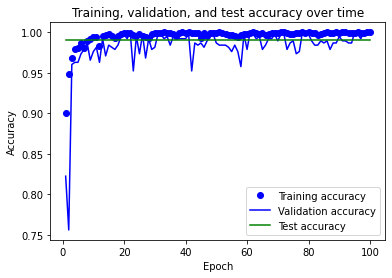

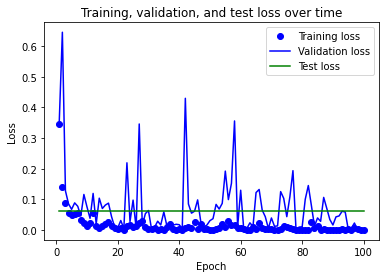

Final training accuracy: 100.00%
Final validation accuracy: 100.00%
Final test accuracy: 99.07%
Final training loss: 0.0000
Final validation loss: 0.0012
Final test loss: 0.0603


In [175]:
# Evaluate model on test set and print accuracy
score = model.evaluate(x_test, y_test, verbose=0)
test_acc = score[1]
test_loss = score[0]
print('Test accuracy: {:.2%}'.format(test_acc))
print('Test loss: {:.4f}'.format(test_loss))

# Plot training, validation, and test accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
test_acc_list = [test_acc] * len(acc)
loss = history.history['loss']
val_loss = history.history['val_loss']
test_loss_list = [test_loss] * len(loss)

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, test_acc_list, 'g', label='Test accuracy')
plt.title('Training, validation, and test accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, test_loss_list, 'g', label='Test loss')
plt.title('Training, validation, and test loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final training, validation, and test accuracy and loss
print('Final training accuracy: {:.2%}'.format(acc[-1]))
print('Final validation accuracy: {:.2%}'.format(val_acc[-1]))
print('Final test accuracy: {:.2%}'.format(test_acc))
print('Final training loss: {:.4f}'.format(loss[-1]))
print('Final validation loss: {:.4f}'.format(val_loss[-1]))
print('Final test loss: {:.4f}'.format(test_loss))


24/24 [==============================] - 0s 4ms/step


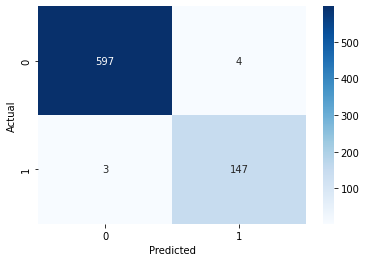

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


12/12 [==============================] - 0s 4ms/step


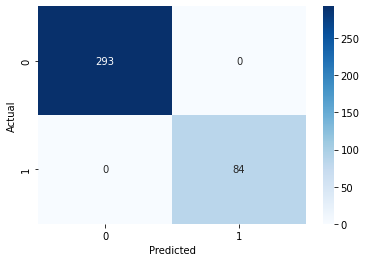

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = model.predict(x_val)
y_pred = (y_pred > 0.5)

# Get confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

24/24 [==============================] - 0s 5ms/step


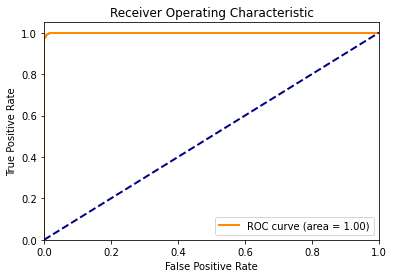

In [178]:
# make predictions on test set
y_pred = model.predict(x_test)

# calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Audio_project Models/added_features_normlized_trucated_totarget_cnn_more_layers.h5')


In [ ]:
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Flatten


In [97]:
# Reshape data for RNN

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[2], 
                          x_train.shape[1], 
                          )
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[2], 
                      x_val.shape[1], 
                      )
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[2], 
                        x_test.shape[1], 
                        )
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2640, 553, 16)
(377, 553, 16)
(751, 553, 16)


In [98]:

sample_shape = x_test.shape[1:]
print(sample_shape)

(553, 16)


In [ ]:
#code adapted from https://www.youtube.com/watch?v=Lq1rnT-MOos&t=3s
# idea for cnn addition from https://www.sciencedirect.com/science/article/abs/pii/S1746809418302337#:~:text=We%20aimed%20at%20learning%20deep%20emotion%20features%20to,from%20speech%20and%20log-mel%20Keywords%20Speech%20emotion%20recognition

In [104]:
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Flatten

model2 = models.Sequential()

# Input shape of audio data: (time_steps, features)
model2.add(LSTM(256, return_sequences=True, input_shape=sample_shape))
model2.add(BatchNormalization())
model2.add(LSTM(256, return_sequences=True))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))

model2.add(TimeDistributed(Dense(128, activation='relu')))
model2.add(BatchNormalization())
model2.add(TimeDistributed(Dense(64, activation='relu')))
model2.add(BatchNormalization())
model2.add(TimeDistributed(Dense(32, activation='relu')))
model2.add(BatchNormalization())
model2.add(TimeDistributed(Dense(16, activation='relu')))
model2.add(BatchNormalization())

model2.add(Conv1D(64, 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))

model2.add(Conv1D(128, 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid')) # output layer

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])



In [105]:
model_checkpoint = ModelCheckpoint('best_rnn_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
history2 = model2.fit(x_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(x_val, y_val),
                    callbacks=[model_checkpoint])


Epoch 1/100
83/83 [==============================] - ETA: 0s - loss: 0.3424 - acc: 0.8837
Epoch 1: val_loss improved from inf to 2.80861, saving model to best_rnn_model_weights.h5
83/83 [==============================] - 65s 89ms/step - loss: 0.3424 - acc: 0.8837 - val_loss: 2.8086 - val_acc: 0.2228
Epoch 2/100
83/83 [==============================] - ETA: 0s - loss: 0.1395 - acc: 0.9576
Epoch 2: val_loss did not improve from 2.80861
83/83 [==============================] - 6s 77ms/step - loss: 0.1395 - acc: 0.9576 - val_loss: 6.5868 - val_acc: 0.2759
Epoch 3/100
83/83 [==============================] - ETA: 0s - loss: 0.0847 - acc: 0.9773
Epoch 3: val_loss did not improve from 2.80861
83/83 [==============================] - 6s 75ms/step - loss: 0.0847 - acc: 0.9773 - val_loss: 5.0687 - val_acc: 0.3607
Epoch 4/100
83/83 [==============================] - ETA: 0s - loss: 0.0876 - acc: 0.9701
Epoch 4: val_loss improved from 2.80861 to 0.78081, saving model to best_rnn_model_weights.h5
8

Test accuracy: 98.80%
Test loss: 0.0368


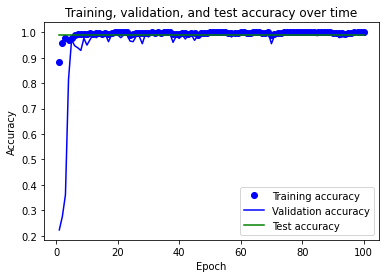

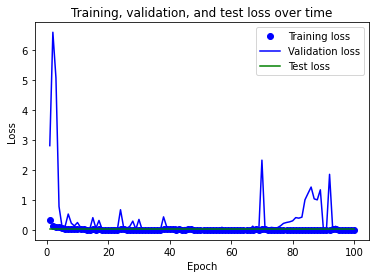

Final training accuracy: 100.00%
Final validation accuracy: 99.47%
Final test accuracy: 98.80%
Final training loss: 0.0005
Final validation loss: 0.0160
Final test loss: 0.0368


In [110]:
# Evaluate model on test set and print accuracy
score = model2.evaluate(x_test, y_test, verbose=0)
test_acc = score[1]
test_loss = score[0]
print('Test accuracy: {:.2%}'.format(test_acc))
print('Test loss: {:.4f}'.format(test_loss))

# Plot training, validation, and test accuracy and loss
acc = history2.history['acc']
val_acc = history2.history['val_acc']
test_acc_list = [test_acc] * len(acc)
loss = history2.history['loss']
val_loss = history2.history['val_loss']
test_loss_list = [test_loss] * len(loss)

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, test_acc_list, 'g', label='Test accuracy')
plt.title('Training, validation, and test accuracy over time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, test_loss_list, 'g', label='Test loss')
plt.title('Training, validation, and test loss over time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print final training, validation, and test accuracy and loss
print('Final training accuracy: {:.2%}'.format(acc[-1]))
print('Final validation accuracy: {:.2%}'.format(val_acc[-1]))
print('Final test accuracy: {:.2%}'.format(test_acc))
print('Final training loss: {:.4f}'.format(loss[-1]))
print('Final validation loss: {:.4f}'.format(val_loss[-1]))
print('Final test loss: {:.4f}'.format(test_loss))


24/24 [==============================] - 2s 33ms/step


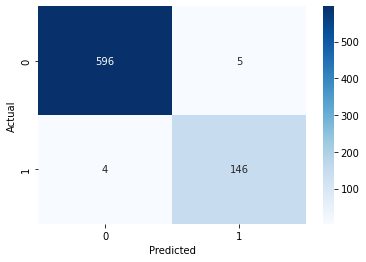

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = model2.predict(x_test)
y_pred = (y_pred > 0.5)

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


12/12 [==============================] - 0s 37ms/step


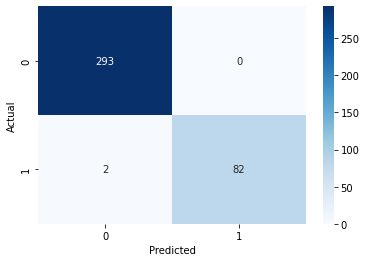

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = model2.predict(x_val)
y_pred = (y_pred > 0.5)

# Get confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

24/24 [==============================] - 1s 32ms/step


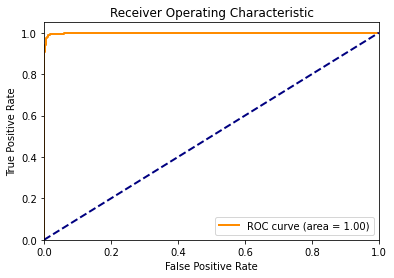

In [113]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# make predictions on test set
y_pred = model2.predict(x_test)

# calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Audio_project Models/rnn_with_1d_cnn_layer.h5')

IPython.display allows you to play audio in browser

In [ ]:
# Throngler refered to as X
from IPython.display import Audio

audio_file = '/content/drive/MyDrive/audio for inference/2023_02_24_15_41_57.wav'
Audio(audio_file)

In [91]:
#Cow 
from IPython.display import Audio

audio_file = '/content/drive/MyDrive/audio for inference/2023_02_24_15_46_01.wav'
Audio(audio_file)

In [183]:
#Artichoke 
from IPython.display import Audio

audio_file = '/content/drive/MyDrive/audio for inference/2023_02_24_15_46_06.wav'
Audio(audio_file)

In [ ]:
# Function: Create MFCC from given path with normalization
def calc_mfcc(path):
    
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    
    # Normalize audio signal
    signal_norm = librosa.util.normalize(signal)
    
    # Create MFCCs from normalized sound clip
    mfccs = python_speech_features.base.mfcc(signal_norm, 
                                            samplerate=fs,
                                            winlen=0.025,# Winlen time used per frame 
                                            winstep=0.01, 
                                            numcep=num_mfcc,
                                            nfilt=26,# default
                                            nfft=512,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    
    return mfccs.transpose()

In [90]:
def extract_features_single(x, len_mfcc=553):
    out_x = []
    # Create MFCCs
    mfccs = calc_mfcc(x)

    # Only keep MFCCs with length between 16 and 553
    if 16 <= mfccs.shape[1] <= len_mfcc:
        # Pad or truncate MFCCs as necessary
        if mfccs.shape[1] < len_mfcc:
            pad_width = ((0, 0), (0, len_mfcc - mfccs.shape[1]))
            mfccs = np.pad(mfccs, pad_width=pad_width, mode='constant')
        elif mfccs.shape[1] > len_mfcc:
            mfccs = mfccs[:, :len_mfcc]
        
        out_x.append(mfccs.T)

    # Convert lists to arrays and transpose dimensions
    out_x = np.array(out_x).transpose((0, 2, 1))
    
    return out_x

MODEL 1 Inference

In [151]:

X = extract_features_single('/content/drive/MyDrive/audio for inference/2023_02_24_15_41_57.wav', len_mfcc=553)

In [154]:
X = X.reshape(X.shape[0], 
                          X.shape[1], 
                          X.shape[2], 
                          1)

In [155]:
model.predict(X)

1/1 [==============================] - 0s 19ms/step


array([[0.]], dtype=float32)

1/1 [==============================] - 0s 31ms/step


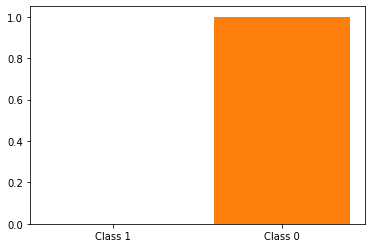

In [179]:
model.predict(X)
pred = model.predict(X)
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

In [163]:
cow = extract_features_single('/content/drive/MyDrive/audio for inference/2023_02_24_15_46_01.wav', len_mfcc=553)

In [164]:
cow = cow.reshape(cow.shape[0], 
                          cow.shape[1], 
                          cow.shape[2], 
                          1)

1/1 [==============================] - 0s 24ms/step


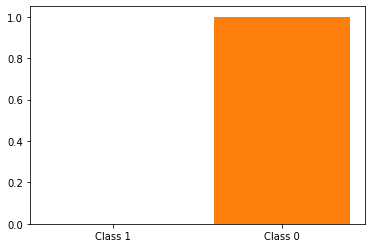

In [180]:
model.predict(cow)
pred = model.predict(cow)
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

In [169]:
artichoke = extract_features_single('/content/drive/MyDrive/audio for inference/2023_02_24_15_46_06.wav',len_mfcc=553)

In [171]:
artichoke = artichoke.reshape(artichoke.shape[0], 
                          artichoke.shape[1], 
                          artichoke.shape[2], 
                          1)

1/1 [==============================] - 0s 23ms/step


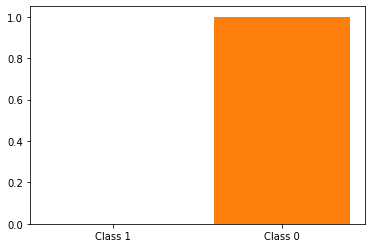

In [181]:
model.predict(artichoke)
pred = model.predict(artichoke)
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

In [92]:
cow = extract_features_single('/content/drive/MyDrive/audio for inference/2023_02_24_15_46_01.wav', len_mfcc=553)

In [95]:
cow = cow.reshape(cow.shape[0], 
                          cow.shape[1], 
                          cow.shape[2], 
                         1 )

1/1 [==============================] - 0s 33ms/step


array([[0.99999666]], dtype=float32)

1/1 [==============================] - 0s 100ms/step


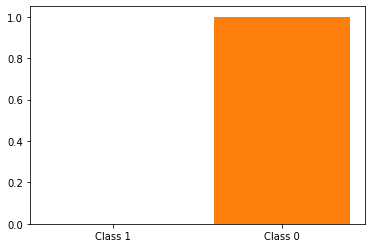

In [96]:
pred = model.predict(cow)
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

Model2 Inference

In [115]:
cow = cow.reshape(cow.shape[0], 
                          cow.shape[2], 
                          cow.shape[1], 
                          )

1/1 [==============================] - 0s 140ms/step


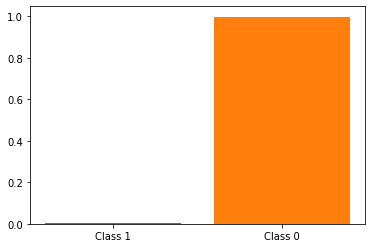

In [117]:
# Flatten a single item
cow_flattened = cow[0].flatten()

# Reshape the flattened item back to the original shape, with a batch size of 1
cow_flattened = cow_flattened.reshape(1, cow[0].shape[1], cow[0].shape[0])

# Predict on the flattened data
pred = model2.predict(cow_flattened)

# Plot the prediction results
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

1/1 [==============================] - 0s 49ms/step


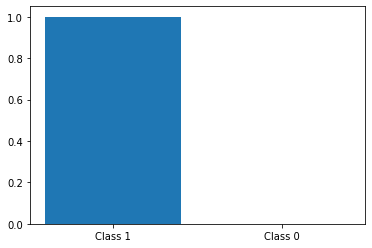

In [121]:
# Flatten a single item
Xflattened = X[0].flatten()

# Reshape the flattened item back to the original shape, with a batch size of 1
Xflattened = Xflattened.reshape(1, X[0].shape[1], X[0].shape[0])

# Predict on the flattened data
pred = model2.predict(Xflattened)

# Plot the prediction results
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

In [122]:
artichoke = extract_features_single('/content/drive/MyDrive/audio for inference/2023_02_24_15_46_06.wav',len_mfcc=553)

1/1 [==============================] - 0s 91ms/step


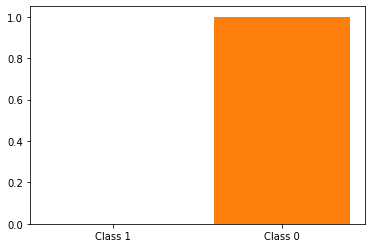

In [123]:
# Flatten a single item
artichokeflattened = artichoke[0].flatten()

# Reshape the flattened item back to the original shape, with a batch size of 1
artichokeflattened = artichokeflattened.reshape(1, artichoke[0].shape[1], artichoke[0].shape[0])

# Predict on the flattened data
pred = model2.predict(artichokeflattened)

# Plot the prediction results
plt.bar(0, pred[0][0])
plt.bar(1, 1-pred[0][0])
plt.xticks([0,1], ['Class 1', 'Class 0'])
plt.show()

The first cnn model is a bit more with categorizing targets as negatives. The combined cnn and rnn appears to produce more accuarate results 